# RSI (상대강도지수 relative strength index)
- 1978년 Welles Wilders라는 사람이 가격의 상승과 하락 추세에서 상승 폭과 하락 폭을 계산하여 그 강도를 백분율로 계산해 현재 가격의 상태를 평가하고자 만든 기술적 지표
- 주식 또는 기타 자산 가격의 과매수 또는 과매도 상태를 평가하기 위해 최근 가격 변화의 규모를 측정하는 기술 분석에 사용되는 모멘텀 지표
- 주식 또는 자산의 주요 추세는 지표의 수치를 올바르게 이해하는 데 중요한 도구
- 70 이상의 값이 증권이 과매수 또는 과대 평가되고 있음을 나타냄, 추세 반전 또는 가격 조정 조정에 대비할 수 있다
- 30 이하이면 과매도 또는 저평가 상태를 나타냄

- MACD 와 유사한 아이디어에서 시작
- MACD는 횡보 진행 장에서 잘못된 시그널을 남발
    -  기간평균에 따른 문제
- RSI
    - 오름과 내림의 구분 전일비 변화량의 평균값-> 강도
        * 과매수상태인지 과매도 상태인지를 파악
    - 요소
        * U(ups)
        * D(downs)
        * AU(Average Ups) 평균상승분: 전일대비 상승한날의 평균
        * AD(Average Downs) 평균하락분: 전일대비 하락한날의 평균
    - RS(relative strength):AU/AD
        * RSI=RS/(1+RS)
        * RSI=(AU/AD)/(1+AU/AD)=AU/(AU+AD)
    - 단점
        * 지속상승장과 지속 하락장에서 잘못된 시그널을 보낼수 있음

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def seldata(cols=['sday','sclose'], where='where sday>"2022-01-01" order by sday asc'):
    fname='_db/nstock.db'
    with sqlite3.connect(fname) as conn: # 사용할 SQLite DB파일 오픈
        cur=conn.cursor() # cursor 생성
        coltxt=','.join(cols)
        sql='select '+coltxt+' from stockdb '+where
        print(sql)
        res=cur.execute(sql).fetchall() # sql쿼리 실행
    return res

res=seldata()    
res[:5]

select sday,sclose from stockdb where sday>"2022-01-01" order by sday asc


[('2022-01-03', 128500),
 ('2022-01-04', 128500),
 ('2022-01-05', 125500),
 ('2022-01-06', 125000),
 ('2022-01-07', 127000)]

In [3]:
cols=['sday','sclose']
df = pd.DataFrame(res,columns=cols)
mdf=df.set_index('sday')
mdf.tail()

,sclose
sday,
2022-05-06,107500
2022-05-09,107500
2022-05-10,110000
2022-05-11,110500
2022-05-12,110500


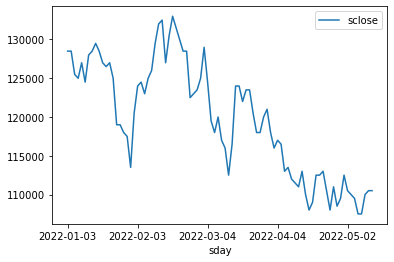

In [5]:
mdf.plot()
plt.show()

In [31]:
wsize=10
sigsize=5
beforeP=mdf.iloc[0,:]['sclose']
#print(beforeP)

for i,row in mdf.iterrows():
    if (row['sclose']>beforeP):
        mdf.loc[i,'U']=row['sclose']-beforeP
        mdf.loc[i,'D']=0
    else:
        mdf.loc[i,'D']=beforeP-row['sclose']
        mdf.loc[i,'U']=0
    beforeP=row['sclose']
mdf['AU']=mdf['U'].rolling(window=wsize).mean()
mdf['AD']=mdf['D'].rolling(window=wsize).mean()
rdf=mdf.fillna(0)
rdf['RSI']=rdf['AU']/(rdf['AU']+rdf['AD']+0.0000001)
rdf['Rsig']=rdf['RSI'].ewm(span=5).mean()
rdf.head()

,sclose,U,D,AU,AD,RSI,Rsig
sday,,,,,,,
2022-01-03,128500,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-04,128500,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-05,125500,0.0,3000.0,0.0,0.0,0.0,0.0
2022-01-06,125000,0.0,500.0,0.0,0.0,0.0,0.0
2022-01-07,127000,2000.0,0.0,0.0,0.0,0.0,0.0


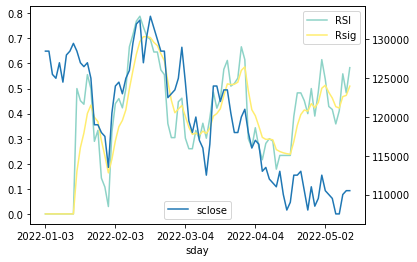

In [51]:
fig,ax1=plt.subplots()
rdf[['RSI','Rsig']].plot(ax=ax1,cmap='Set3')
ax2=ax1.twinx()
rdf['sclose'].plot(ax=ax2).legend(loc='lower center')

In [33]:
def simStock(mdf,stxt='shortmv',ltxt='longmv'):
    findex=mdf.iloc[:1,:].index[0]
    lindex=mdf.iloc[-1:,:].index[0]
    lindex
    invest=200000
    beforePos=-1
    beforeHold=0

    for i,row in mdf.iloc[10:,:].iterrows():
        if(row[stxt]>=row[ltxt]):
            nowpos=1 # short 상위
        else:
            nowpos=-1 # short 하위
        if beforePos==-1 and nowpos==1 and beforeHold==0:
            timing=1# 매수타이밍
            hold=1
            mdf.loc[i,'cash']=-row['sclose']
            mdf.loc[i,'hold']=1
        elif beforePos==1 and nowpos==-1 and beforeHold==1:
            timing=-1# 매수타이밍
            hold=0
            mdf.loc[i,'cash']=row['sclose']
            mdf.loc[i,'hold']=0
        else:
            mdf.loc[i,'cash']=0
            timing=0 # 홀드
            hold=beforeHold
            mdf.loc[i,'hold']=beforeHold
        beforeHold=hold
        beforePos=nowpos
        mdf.loc[findex,'cash']=invest
        mdf['cumcash']=mdf['cash'].cumsum()
        mdf['balalce']=mdf['sclose']*mdf['hold']+mdf['cumcash']
    mdf.tail()
    ecash=mdf.loc[lindex,'balalce']-invest
    erate=ecash/invest
    return(invest,ecash,erate)

In [34]:
simStock(rdf,stxt='RSI',ltxt='Rsig')

(200000, -5000.0, -0.025)